In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os


In [21]:
import tensorflow as tf
import os
import zipfile

# 1. Download the file
print("Downloading...")
_URL = 'https://download.mlcc.google.com/mledu-datasets/cats_and_dogs_filtered.zip'
file_name = 'cats_and_dogs.zip'

# Get the default cache directory for Keras utilities where get_file stores downloads
# tf.keras.utils.get_file stores files in ~/.keras/datasets by default
path_to_zip = os.path.join(os.path.expanduser('~'), '.keras', 'datasets', file_name)

# Ensure a fresh download by removing the file if it exists and is potentially corrupted
if os.path.exists(path_to_zip):
    print(f"Deleting existing file at: {path_to_zip}")
    os.remove(path_to_zip)

# Now, download the file. tf.keras.utils.get_file will re-download if it doesn't exist
# or if hash validation fails. We set extract=False because we want to manually extract.
path_to_zip = tf.keras.utils.get_file(file_name, origin=_URL, extract=False, archive_format='zip')

# 2. Extract manually to a specific local directory
local_extract_path = '/tmp/cats_and_dogs_project'
# Create the extraction directory if it doesn't exist
os.makedirs(local_extract_path, exist_ok=True)

try:
    with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
        zip_ref.extractall(local_extract_path)
    print(f"Extraction successful to {local_extract_path}")
except zipfile.BadZipFile as e:
    print(f"Error extracting zip file: {e}. The file might be corrupted.")
    print(f"Attempting to re-download by deleting {path_to_zip} and retrying extraction.")
    if os.path.exists(path_to_zip):
        os.remove(path_to_zip)
    # Re-attempt download and extraction
    path_to_zip = tf.keras.utils.get_file(file_name, origin=_URL, extract=False, archive_format='zip')
    with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
        zip_ref.extractall(local_extract_path)
    print(f"Re-download and extraction successful to {local_extract_path}")


# 3. Define the new PATH (The zip usually creates a subfolder with its name)
PATH = os.path.join(local_extract_path, 'cats_and_dogs_filtered')

# 4. Set up the specific directories
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# 5. Verify
if os.path.exists(train_cats_dir):
    print("Success! Folders found.")
    print(f"Total training cat images: {len(os.listdir(train_cats_dir))}")
    print(f"Total training dog images: {len(os.listdir(train_dogs_dir))}")
else:
    print("Still not found. Let's see what is actually inside the folder:")
    print(os.listdir(local_extract_path))

Downloading...
Deleting existing file at: /root/.keras/datasets/cats_and_dogs.zip
68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Extraction successful to /tmp/cats_and_dogs_project
Success! Folders found.
Total training cat images: 1000
Total training dog images: 1000


In [22]:
# Step 3: Create data generators with augmentation
IMG_SIZE = (160, 160)          # VGG16 usually expects 224×224, but 160 is faster for demo
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [23]:
# Step 4: Load pre-trained VGG16 (without top classification layers)
base_model = VGG16(weights='imagenet',
                   include_top=False,           # remove final dense layers
                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
# Freeze the base model (very important in transfer learning)
base_model.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
# Step 5: Build our new model on top of VGG16
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),          # better than Flatten for conv base
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')     # binary classification → sigmoid
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [25]:
# Step 6: Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [26]:
# Step 7: Train the top layers first (feature extractor frozen)
print("\nPhase 1: Training top layers only...")
history_phase1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=1
)



Phase 1: Training top layers only...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 417ms/step - accuracy: 0.5557 - loss: 0.6986 - val_accuracy: 0.7520 - val_loss: 0.6078
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 296ms/step - accuracy: 0.6260 - loss: 0.6405 - val_accuracy: 0.8030 - val_loss: 0.5405
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - accuracy: 0.7131 - loss: 0.5723 - val_accuracy: 0.7940 - val_loss: 0.5034
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 297ms/step - accuracy: 0.7180 - loss: 0.5539 - val_accuracy: 0.8140 - val_loss: 0.4610
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 308ms/step - accuracy: 0.7618 - loss: 0.5066 - val_accuracy: 0.8240 - val_loss: 0.4333
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 297ms/step - accuracy: 0.7614 - loss: 0.5029 - val_accuracy: 0.8320 - val_loss: 0.4104
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 298ms/step - accuracy: 0.7967 - loss: 0.4527 - val_accuracy: 0.8290 - val_loss: 0.4046
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - accuracy: 0.7971 - loss: 0.4507 - val_accu

In [27]:
# Step 8: Unfreeze some layers and fine-tune (optional Phase 2)
print("\nUnfreezing last few conv blocks for fine-tuning...")
base_model.trainable = True
# Freeze all layers except the last 4 blocks (example)
for layer in base_model.layers[:-16]:
    layer.trainable = False
# Re-compile with lower learning rate (very important!)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
print("Phase 2: Fine-tuning...")
history_phase2 = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=1
)



Unfreezing last few conv blocks for fine-tuning...
Phase 2: Fine-tuning...
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 615ms/step - accuracy: 0.8655 - loss: 0.3176 - val_accuracy: 0.9220 - val_loss: 0.1879
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 361ms/step - accuracy: 0.9314 - loss: 0.1745 - val_accuracy: 0.9480 - val_loss: 0.1298
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 372ms/step - accuracy: 0.9512 - loss: 0.1307 - val_accuracy: 0.9520 - val_loss: 0.1260
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 364ms/step - accuracy: 0.9527 - loss: 0.1046 - val_accuracy: 0.9640 - val_loss: 0.0938
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9659 - loss: 0.0779 - val_accuracy: 0.9520 - val_loss: 0.1147
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 365ms/step - accuracy: 0.9591 - loss: 0.0892 - val_accuracy: 0.9680 - val_loss: 0.0885
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 369ms/step - accuracy: 0.9795 - loss: 0.0623 - val_accuracy: 0.9690 - val_loss: 0.0872
Epoch 8/10
63/63 ━━━━

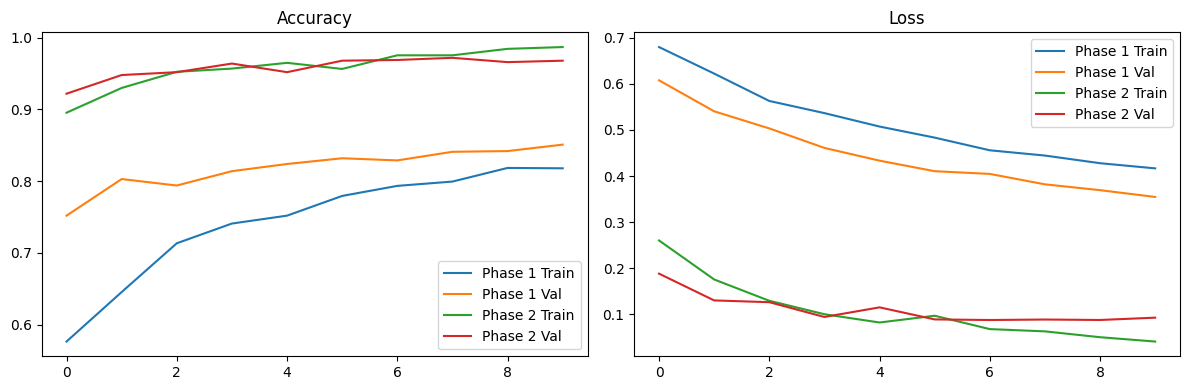

In [28]:
# Step 9: Plot training history
def plot_history(histories, titles):
    plt.figure(figsize=(12, 4))
    for i, hist in enumerate(histories):
        plt.subplot(1, 2, 1)
        plt.plot(hist.history['accuracy'], label=f'{titles[i]} Train')
        plt.plot(hist.history['val_accuracy'], label=f'{titles[i]} Val')
        plt.title('Accuracy')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(hist.history['loss'], label=f'{titles[i]} Train')
        plt.plot(hist.history['val_loss'], label=f'{titles[i]} Val')
        plt.title('Loss')
        plt.legend()
    plt.tight_layout()
    plt.show()
plot_history([history_phase1, history_phase2], ['Phase 1', 'Phase 2'])

In [29]:
# Step 10: Evaluate final model
loss, acc = model.evaluate(validation_generator, verbose=0)
print(f"\nFinal validation accuracy: {acc:.4f} ({acc*100:.2f}%)")
# Optional: Save model
# model.save("vgg16_cats_dogs_transfer.h5")
print("Practical 2 completed.")


Final validation accuracy: 0.9680 (96.80%)
Practical 2 completed.
